In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise

In [38]:
from hamiltonian_generator import Hamiltonian
import qutip as qt


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 5e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [3,1])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
# Make diagonal term subtract the first element
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
# noise = qt.Qobj(noise_matrix)


In [39]:
sample_rate = 1               # per ns
tnoise_max = int(1e5)             # number of samples

omega_ir = 1/tnoise_max*2*np.pi
S0 = 5e-5
relative_PSD_strength = S0**2
num_realizations = 100
ifwhite = False               # True for white noise, False for 1/f noise
# Generate white noise (unit variance) trajectories
N = tnoise_max * sample_rate
gn = GenerateNoise(sample_rate, tnoise_max, relative_PSD_strength, num_realizations, ifwhite)

In [40]:
# Generate and save trajectories
trajs = gn.generate_colored_noise()
# np.save('trajectories.npy', trajs)

# # Load trajectories
# trajs = np.load('trajectories.npy')
trajsp = (np.cos(phi_ex*np.pi)*(np.cos(trajs*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajs*np.pi))


In [48]:

(np.cos(phi_ex*np.pi)*(np.cos(1e-5*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(1e-5*np.pi))

np.float64(-1.8466217535781088e-05)

Numerically evaluatd power: 6.163686542727607e-08
Numerically evaluated variance: 6.163322883514389e-08
Analytically evaluated power: 5.909889142205142e-08
PSD fit: power law v.s frequency = -0.9997, fitted intercept = -8.5878, fitted S0 = 5.082688e-05 Φ₀


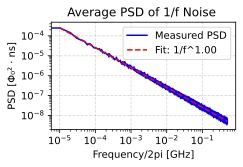

In [41]:
S0 = gn.analyze_noise_psd(trajs)

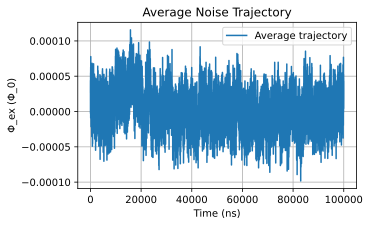

In [42]:
# Sum all trajectories and take average
avg_traj = np.mean(trajs, axis=0)

plt.figure(figsize=(5, 3))
plt.plot(avg_traj, label='Average trajectory')
plt.xlabel('Time (ns)')
plt.ylabel('Φ_ex (Φ_0)')
plt.title('Average Noise Trajectory')
plt.legend()
plt.grid(True)
plt.show()

-0.002257798283383668
Numerically evaluatd power: 0.0001216277166331486
Numerically evaluated variance: 0.00012161950280828257
Analytically evaluated power: 5.909889142205142e-08
PSD fit: power law v.s frequency = -0.9997, fitted intercept = -5.2926, fitted S0 = 2.257811e-03 Φ₀


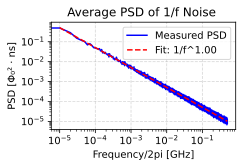

In [47]:
print(S0*(sc.omega_s_per - sc.omega_s)/1e-6)
S0P = gn.analyze_noise_psd(trajsp*np.real(noise_matrix[1,1]))

In [36]:
(sc.omega_s_per - sc.omega_s)/1e-6

np.float64(-44.421347624279406)

In [23]:
from joblib import Parallel, delayed
# Initialize arrays to store results
all_expect_values = []
t_max = 100
N = t_max
time_points = np.linspace(0, t_max, N)  # Time points matching noise trajectory

# Initial state using qt.basis
initial_state = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
sigma_x = qt.sigmax()
sigma_z = -qt.sigmaz()
def simulate_trajectory(i):
    # Create time-dependent Hamiltonian with noise
    H = [[24.056*qt.Qobj([[0, 0], [0, 1]]), lambda t, args: trajs[i][int(t * sample_rate)] if t < t_max else 0]]
    # Solve the dynamics
    result = qt.sesolve(H, initial_state, time_points, e_ops=[sigma_x])
    # Return the expectation values
    return result.expect[0]

# Loop through each noise trajectory in parallel
all_expect_values = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

# Convert to numpy array for easier analysis
all_expect_values = np.array(all_expect_values)


In [24]:
# # Calculate the average over all trajectories
# avg_sigmax = np.mean(all_expect_values, axis=0)

# # Define exponential decay function for fitting
# def exp_decay(t, T2):
#     return np.exp(-t**2/ T2**2)  # No amplitude parameter

# # Fit the data with exponential decay
# from scipy.optimize import curve_fit
# params, pcov = curve_fit(exp_decay, time_points, avg_sigmax, p0=[1000])
# T2_fit = params[0]

# # Plot the results with the fit
# plt.figure(figsize=(10, 6))
# plt.plot(time_points, avg_sigmax, 'b-', label='Simulation data')
# plt.plot(time_points, exp_decay(time_points, T2_fit), 'r--', 
#          label=f'Exp fit: T2 = {T2_fit:.2f} ns')
# plt.xlabel('Time (ns)')
# plt.ylabel('⟨σ_x⟩')
# plt.title(f'Average σ_x expectation value over {num_realizations} noise trajectories')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Print the fitted parameters
# print(f"Fitted T2 time = {T2_fit:.4f} ns")


In [25]:
# # Theoretical prediction for T2 with 1/f noise
# T2_theory = 1/(24.056*S0*np.sqrt(2)*np.sqrt(abs(np.log(omega_ir*t_max))))
# print(f"Theoretical T2 prediction = {T2_theory:.4f} ns")

In [26]:
from hamiltonian_generator import Hamiltonian
import qutip as qt
from joblib import Parallel, delayed

phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [2,1])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
# Make diagonal term subtract the first element
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = noise_matrix
noise = qt.Qobj(sc.noise)


In [27]:
noise_matrix = sc.noise.copy()
first_element = noise_matrix[0, 0]
for i in range(noise_matrix.shape[0]):
    noise_matrix[i, i] -= first_element
noise = qt.Qobj(noise_matrix)


In [28]:
_, state_and_sigmax, get_projector = sc.setup_floquet_system(A , optimal_omega)
U_init , _ ,_= state_and_sigmax(0)
init_state = U_init[:,0]
init_state = qt.Qobj(init_state)

In [29]:
from system import *
# Diagonalize the rotating frame Hamiltonian
H0_rot = H0.full() - optimal_omega * np.diag(np.arange(H0.shape[0])) + A/2 * H_control.full()
evals_rot, U = np.linalg.eigh(H0_rot)
evals_rot, U = sort_eigenpairs(evals_rot, U)
Ud = U.T.conj()
dressed0 = qt.Qobj(U[:,0])
dressed1 = qt.Qobj(U[:,1])
P0 = dressed0 * dressed0.dag()
P1 = dressed1 * dressed1.dag()

In [30]:
dressed0

Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
Qobj data =
[[-0.97255329+0.j       ]
 [-0.00562787-0.2326122j]]

In [31]:
me = (Ud@np.array([[0,0],[0,1]])@U)[0,1]
detu = (evals_rot[1]-evals_rot[0])/2/np.pi

In [32]:
me**1

np.complex128(0.2262939584917956+8.673617379884035e-19j)

In [33]:
# Perform quantum simulation with noise trajectories
from qutip import sesolve, basis, sigmaz, sigmax

# Initialize arrays to store results
# all_expect_values = []
t_max =60000  # Reduced from 10000 to avoid integration issues
N = t_max
time_points = np.linspace(0, t_max, N)

# Initial state from previous cells
initial_state = init_state

def simulate_trajectory(i):
    # Create Hamiltonian with increased nsteps for better integration
    traj = np.cos(phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
    H = [qt.Qobj(H0_rot), [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
    
    # Use options to increase nsteps and improve integration stability
    opts = {'nsteps': t_max*1, 'atol': 1e-10, 'rtol': 1e-8}
    result = qt.sesolve(H, initial_state, time_points, options=opts)
    
    dim = noise.shape[0]
    avg_values = np.zeros((dim + 2, len(time_points)))
    
    for j, t in enumerate(time_points):
        state_t = result.states[j]
        avg_values[2, j] = qt.expect(P0, state_t)
        avg_values[3, j] = qt.expect(P1, state_t)
    
    return avg_values

result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

# Convert to numpy array for easier analysis
result = np.array(result)


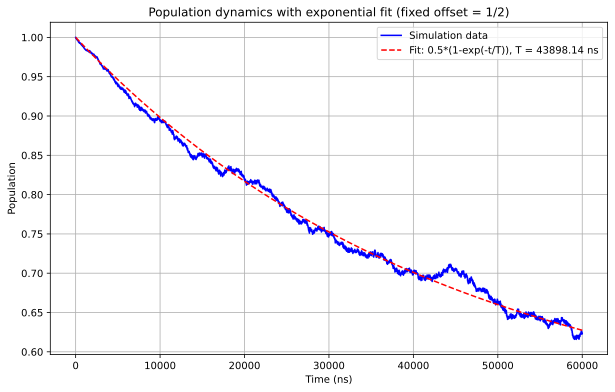

Fitted T = 43898.1392 ns
Fixed offset = 0.5


In [35]:
from scipy.optimize import curve_fit

# Define exponential decay function with fixed offset of 1/2
def exp_decay_fixed_offset(t, T):
    return 0.5 * (1 + np.exp(-t / T))

avg_expect_values = np.mean(result, axis=0)

# Fit the data with exponential decay (fixed offset = 1/2)
params, pcov = curve_fit(exp_decay_fixed_offset, time_points, avg_expect_values[2], p0=[1000])
T_fit = params[0]

# Plot the results with the fit
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_expect_values[2], 'b-', label='Simulation data')
plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
         label=f'Fit: 0.5*(1-exp(-t/T)), T = {T_fit:.2f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title('Population dynamics with exponential fit (fixed offset = 1/2)')
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print(f"Fitted T = {T_fit:.4f} ns")
print(f"Fixed offset = 0.5")

In [32]:
1/((S0P**2/detu)*(me)**2)/2

np.complex128(-972055.6724001719-7.451590519782522e-12j)

In [34]:
detu

np.float64(-0.021524230049624338)

In [21]:
detu

np.float64(-0.006786208101637841)

In [22]:
T_fit

np.float64(204991.37481616985)

In [23]:
1/147606

6.774792352614392e-06

In [24]:
# # Perform quantum simulation with noise trajectories
# from qutip import sesolve, basis, sigmaz, sigmax

# # Initialize arrays to store results
# # all_expect_values = []
# t_max = 15000  # Reduced from 10000 to avoid integration issues
# N = t_max
# time_points = np.linspace(0, t_max, N)

# # Initial state from previous cells
# initial_state = init_state

# def simulate_trajectory(i):
#     # Create Hamiltonian with increased nsteps for better integration
#     traj = np.cos(phi_ex*np.pi)*(np.cos(trajs[i]*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajs[i]*np.pi)
#     H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)],
#          [noise, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0]]
    
    
#     # Use options to increase nsteps and improve integration stability
#     opts = qt.Options(nsteps=t_max*10, atol=1e-10, rtol=1e-8)
#     result = qt.sesolve(H, initial_state, time_points, options=opts)
    
#     dim = noise.shape[0]
#     avg_values = np.zeros((dim + 2, len(time_points)))
    
#     for j, t in enumerate(time_points):
#         state_t = result.states[j]
#         U, sigmaxc, sigmaxs = state_and_sigmax(t)
#         projectors = get_projector(U)
#         avg_values[0, j] = qt.expect(qt.Qobj(sigmaxc), state_t)
#         avg_values[1, j] = qt.expect(qt.Qobj(sigmaxs), state_t)
#         for k in range(dim):
#             avg_values[k+2, j] = qt.expect(qt.Qobj(projectors[k]), state_t)
    
#     return avg_values

# result = Parallel(n_jobs=-1)(delayed(simulate_trajectory)(i) for i in range(num_realizations))

# # Convert to numpy array for easier analysis
# result = np.array(result)


In [25]:
# from scipy.optimize import curve_fit

# # Define exponential decay function with fixed offset of 1/2
# def exp_decay_fixed_offset(t, T):
#     return 0.5 * (1 + np.exp(-t / T))

# avg_expect_values = np.mean(result, axis=0)

# # Fit the data with exponential decay (fixed offset = 1/2)
# params, pcov = curve_fit(exp_decay_fixed_offset, time_points, avg_expect_values[2], p0=[1000])
# T_fit = params[0]

# # Plot the results with the fit
# plt.figure(figsize=(10, 6))
# plt.plot(time_points, avg_expect_values[2], 'b-', label='Simulation data')
# plt.plot(time_points, exp_decay_fixed_offset(time_points, T_fit), 'r--', 
#          label=f'Fit: 0.5*(1-exp(-t/T)), T = {T_fit:.2f} ns')
# plt.xlabel('Time (ns)')
# plt.ylabel('Population')
# plt.title('Population dynamics with exponential fit (fixed offset = 1/2)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Print the fitted parameters
# print(f"Fitted T = {T_fit:.4f} ns")
# print(f"Fixed offset = 0.5")

In [26]:
68971.7257,70646.386,73875.8044

(68971.7257, 70646.386, 73875.8044)